In [1]:
import msiwarp as mx

from msiwarp.util.read_sbd import read_sbd_meta, read_spectrum_fs
from msiwarp.util.warp import to_mx_peaks, to_mz, to_height, peak_density_mz
from msiwarp.util.warp import spectra_to_triplet, plot_range, get_mx_spectrum
from msiwarp.util.warp import generate_mean_spectrum

import matplotlib.pyplot as plt
import numpy as np


# scaling to test impact of sigma on alignment performance
sigma_1 = 1.5e-4
epsilon = 2.55
slack = 2.0 * epsilon * sigma_1

print("using spectrum {} as reference, sigma: {} ppm, and epsilon: {:0.2f} ppm".format(i_r, sigma_1 * 1e6, slack * 1e6))

fdir = 'datasets/tof-kidney/'

fpath_sbd = fdir + '50um_sample_3neg-centroided-snr.sbd'
fpath_triplets_raw = fdir + 'triplets_raw.dat'
fpath_triplets_warped = fdir + 'triplets_warped.dat'
fpath_dispersion_csv = fdir + 'results/dispersion_100.csv'
fpath_scatter = fdir + 'results/scatter'

# experiment settings
instrument_type = 'tof'
mz_begin = 450
mz_end = 2000

meta = read_sbd_meta(fpath_sbd)
spectra = [get_mx_spectrum(fpath_sbd, meta, i, sigma_1, instrument_type) for i in range(len(meta))]
tic = np.array([m[2] for m in meta])

using spectrum 200 as reference, sigma: 150.0 ppm, and epsilon: 765.00 ppm


In [3]:
n_steps = 50
n_peaks = 30
max_n_nodes = 10
slack = 2.0 * epsilon * sigma_1

params = mx.node_params(mx.Instrument.TOF,
                        n_steps,
                        n_peaks,
                        max_n_nodes,
                        mz_begin,
                        mz_end,
                        slack)

# --------- set reference spectrum ----------
i_r = 200
s_ref = spectra[i_r]

In [4]:
import time

n_cores = 8

t0 = time.time()
warping_funcs = mx.find_optimal_warpings_uni(spectra, s_ref, params, epsilon, n_cores)
t1 = time.time()
print("found optimal warpings in {:0.2f} seconds".format(t1 - t0))

found optimal warpings in 106.07 seconds


176


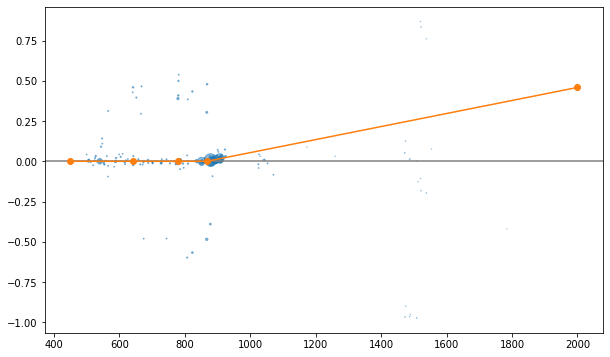

In [91]:
from msiwarp.util.warp import plot_peak_matches, plot_warping

i_s = np.random.choice(len(spectra))
s_s = spectra[i_s]

recal = warping_funcs[i_s]
xw = ([w[0] for w in recal])
yw = np.array([w[1] for w in recal])

pms = mx.overlapping_peak_pairs(s_ref, s_s, epsilon)
n_peak_matches = len(pms)
print(n_peak_matches)
    
_, ax = plt.subplots(figsize=(10,6))
ax.axhline(0, c='tab:gray')
plot_peak_matches(pms, 0.5, 150, ax=ax)
ax.plot(xw, -yw, '-o', c='tab:orange')
plt.show()